In [20]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [21]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [22]:
print(tf.__version__)

2.10.0


In [23]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCH = 5

In [24]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "data/Grape_dataset",
    shuffle=True,
    image_size= (IMAGE_SIZE,IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

Found 9023 files belonging to 4 classes.


In [25]:
class_names = dataset.class_names
class_names

['Black Rot', 'Esca (Black Measles)', 'Healthy', 'Leaf Blight']

In [26]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 0 3 0 1 3 0 3 2 1 2 0 1 1 3 1 2 1 0 0 3 0 0 0 0 3 1 2 0 2 3 2]


In [27]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].shape)


(256, 256, 3)


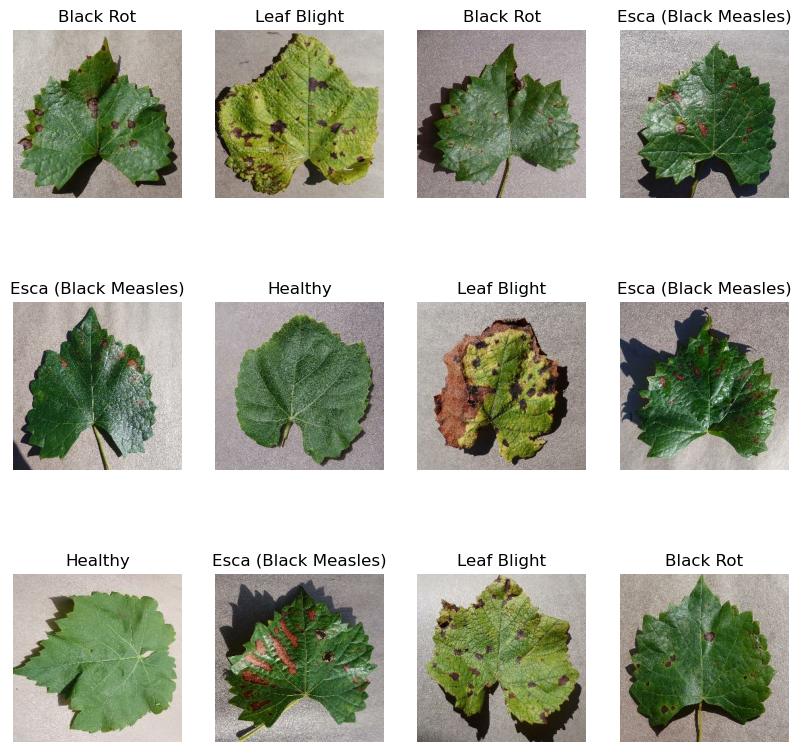

In [28]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [29]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    test_size = int(test_split*ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [30]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [31]:
len(train_ds)

225

In [32]:
len(val_ds)

28

In [33]:
len(test_ds)

29

In [34]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [35]:
# Pre-processing pipeline
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1.0/255)
])

In [36]:
# Random flip and Rotation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

In [37]:
# Define the model
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4
model = models.Sequential([
    layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),  # Input layer specifying the shape
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(n_classes, activation="softmax"),
])

# Print model summary
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 sequential_3 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [38]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['Accuracy']
)

In [39]:
history = model.fit(
    train_ds,
    epochs=EPOCH,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/5
225/225 [==============================] - 431s 2s/step - loss: 0.6522 - Accuracy: 0.7148 - val_loss: 0.6269 - val_Accuracy: 0.7879
Epoch 2/5
225/225 [==============================] - 396s 2s/step - loss: 0.2415 - Accuracy: 0.9042 - val_loss: 0.2723 - val_Accuracy: 0.8951
Epoch 3/5
225/225 [==============================] - 346s 2s/step - loss: 0.1501 - Accuracy: 0.9450 - val_loss: 0.2004 - val_Accuracy: 0.9263
Epoch 4/5
225/225 [==============================] - 344s 2s/step - loss: 0.1129 - Accuracy: 0.9596 - val_loss: 0.1532 - val_Accuracy: 0.9464
Epoch 5/5
225/225 [==============================] - 258s 1s/step - loss: 0.0910 - Accuracy: 0.9678 - val_loss: 0.1748 - val_Accuracy: 0.9386


In [40]:
acc = history.history['Accuracy']
val_acc = history.history['val_Accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

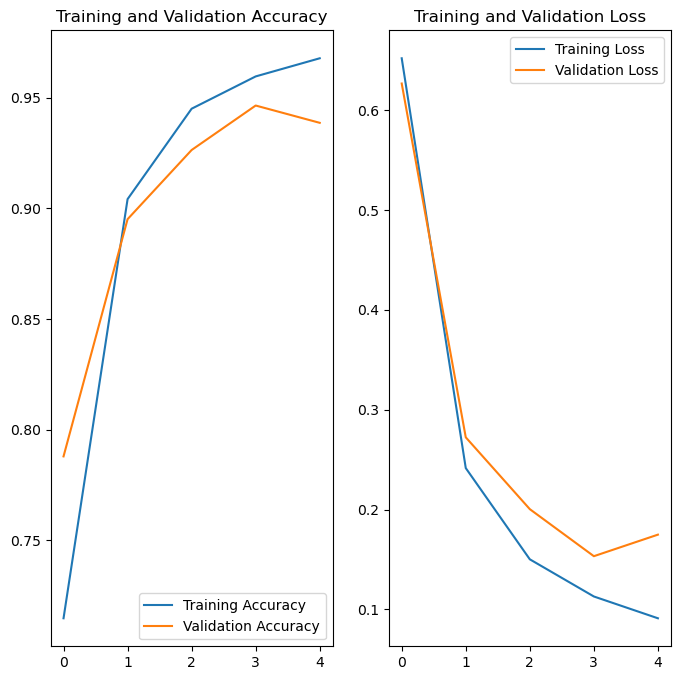

In [41]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCH), acc, label='Training Accuracy')
plt.plot(range(EPOCH), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCH), loss, label='Training Loss')
plt.plot(range(EPOCH), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [42]:
model.evaluate(test_ds)

29/29 [==============================] - 57s 327ms/step - loss: 0.1570 - Accuracy: 0.9397


[0.15703074634075165, 0.9396551847457886]

first image to Predict
first image actual Label: Black Rot
1/1 [==============================] - 2s 2s/step
Predicted Label: Black Rot


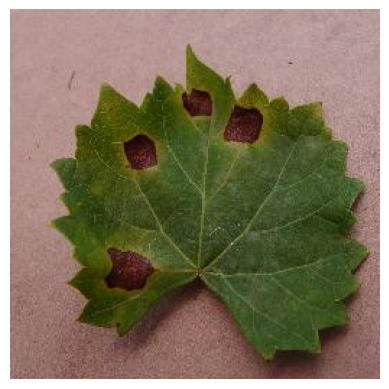

In [43]:
import numpy as np
for image_batch, label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    print('first image to Predict')
    plt.imshow(first_image)
    print("first image actual Label:", class_names[first_label])
    plt.axis("off")

batch_prediction = model.predict(image_batch)
print('Predicted Label:', class_names[np.argmax(batch_prediction[0])])

In [44]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #Create batch

    prediction = model.predict(img_array)

    Predicted_class = class_names[np.argmax(prediction[0])]
    Confidence = round(100*(np.max(prediction[0])), 2)
    return Predicted_class, Confidence

1/1 [==============================] - 0s 49ms/step


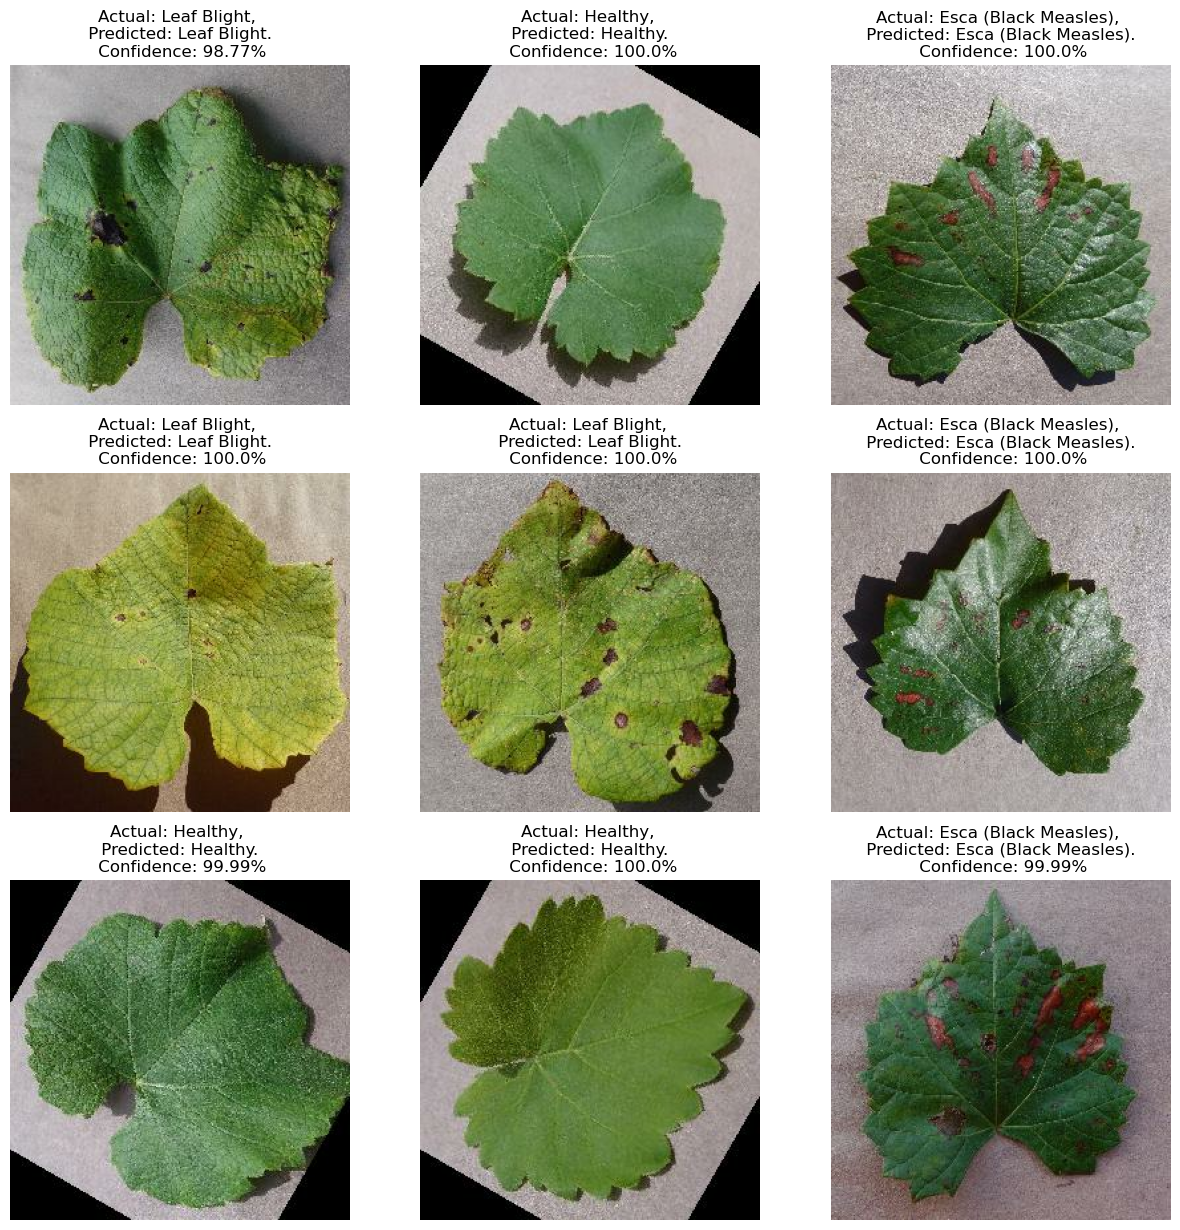

In [45]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        Predicted_class, Confidence = predict(model, images[i].numpy())
        Actual_class = class_names[labels[i]]

        plt.title(f"Actual: {Actual_class}, \n Predicted: {Predicted_class}. \n Confidence: {Confidence}%")
        plt.axis("off")

In [46]:
from tensorflow.keras.models import save_model
# Save the model locally
model.save('cnn_prediction_model_V3')

INFO:tensorflow:Assets written to: cnn_prediction_model_V3\assets


INFO:tensorflow:Assets written to: cnn_prediction_model_V3\assets


In [47]:
import numpy as np
import tensorflow as tf

# Lists to hold predictions and true labels
true_labels = []
predictions = []

# Iterate through the validation dataset
for image_batch, label_batch in val_ds:
    # Make predictions
    preds = model.predict(image_batch)
    preds_labels = np.argmax(preds, axis=-1)
    
    # Extend lists
    true_labels.extend(label_batch.numpy())
    predictions.extend(preds_labels)

# Convert lists to numpy arrays for compatibility with scikit-learn
true_labels = np.array(true_labels)
predictions = np.array(predictions)


1/1 [==============================] - 0s 380ms/step


In [48]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(true_labels, predictions, target_names=class_names, output_dict=True)

# Convert the report to a DataFrame for better readability
import pandas as pd

report_df = pd.DataFrame(report).transpose()
print(report_df)

                      precision    recall  f1-score     support
Black Rot              0.937799  0.823529  0.876957  238.000000
Esca (Black Measles)   0.851145  0.991111  0.915811  225.000000
Healthy                1.000000  0.995595  0.997792  227.000000
Leaf Blight            0.984925  0.951456  0.967901  206.000000
accuracy               0.938616  0.938616  0.938616    0.938616
macro avg              0.943467  0.940423  0.939616  896.000000
weighted avg           0.942632  0.938616  0.938237  896.000000


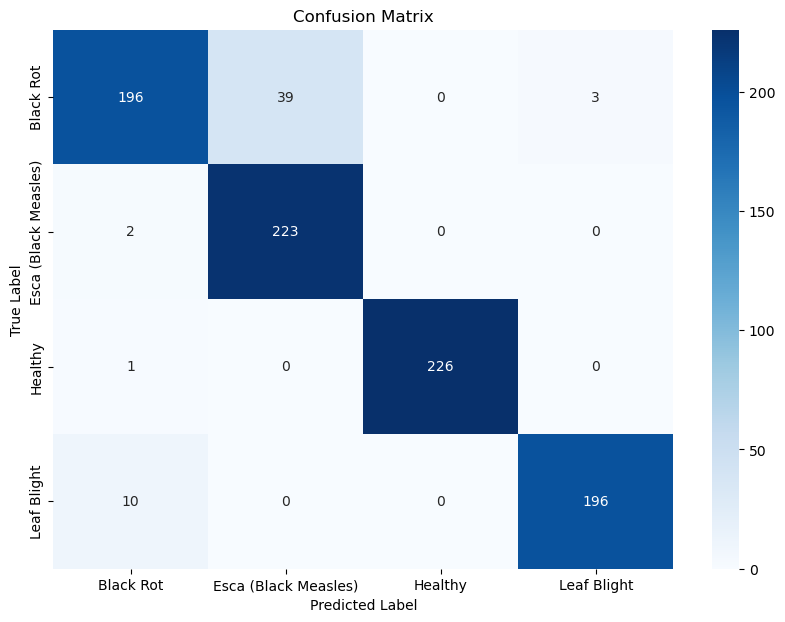

In [49]:
import seaborn as  sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

This result therefore shows an almost perfect CNN classification performance across our categories of grape plant disease:

For each class:
- **Black Rot**, **Esca (Black Measles)**, and **Healthy** have nearly perfect scores.
- **Leaf Blight** has slightly lower precision but perfect recall.

Overall:
- **Accuracy**: 99.67%.
- **Macro avg**: The average performance across classes.
- **Weighted avg**: The overall performance, considering the class distribution.

This model performs exceptionally well across all categories and  demonstrates the effectiveness of CNNs in plant disease classification. The high accuracy and precision scores indicate that the  model is reliable and can be used for real-world applications in grape plant disease diagnosis.


### Class Mapping

In [50]:
# Create class indices dictionary
class_indices = {str(index): name for index, name in enumerate(class_names)}
class_indices

{'0': 'Black Rot',
 '1': 'Esca (Black Measles)',
 '2': 'Healthy',
 '3': 'Leaf Blight'}

In [51]:
import json

# Save class indices to JSON
with open('class_indices.json', 'w') as f:
    json.dump(class_indices, f)

print("Class indices saved to class_indices.json")

Class indices saved to class_indices.json
